Practice implementation for various predictive models

In [124]:
import pandas as pd
import numpy as np
from binance.client import Client
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt

In [125]:
#Read in data
#https://github.com/binance/binance-public-data/

client = Client()

# Set the start date and current date
start_date = "1 Jan, 2020"
end_date = datetime.now().strftime("%d %b, %Y")

# Fetch the klines/candlestick data
klines = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1DAY, start_date, end_date)

# Create a DataFrame
df = pd.DataFrame(klines, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

# Set timestamp as index
df.set_index('timestamp', inplace=True)

# Convert relevant columns to float
float_columns = ['open', 'high', 'low', 'close', 'volume', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']
df[float_columns] = df[float_columns].astype(float)

Part 1 - Just Split into train and test 

In [126]:
df.head()

,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
timestamp,,,,,,,,,,,
2020-01-01,7195.24,7255.0,7175.15,7200.85,16792.388165,1577923199999,1.212145e+08,194010.0,8946.955535,6.459779e+07,0
2020-01-02,7200.77,7212.5,6924.74,6965.71,31951.483932,1578009599999,2.259823e+08,302667.0,15141.611340,1.070608e+08,0
2020-01-03,6965.49,7405.0,6871.04,7344.96,68428.500451,1578095999999,4.950986e+08,519854.0,35595.496273,2.577131e+08,0
2020-01-04,7345.00,7404.0,7272.21,7354.11,29987.974977,1578182399999,2.198742e+08,279370.0,16369.382248,1.200351e+08,0
2020-01-05,7354.19,7495.0,7318.00,7358.75,38331.085604,1578268799999,2.848487e+08,329209.0,19455.369564,1.446001e+08,0


In [127]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'close_time',
       'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume',
       'taker_buy_quote_asset_volume', 'ignore'],
      dtype='object')

In [128]:
df = df.drop(['ignore', 'close_time'], axis=1)

In [129]:
df.head()

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
timestamp,,,,,,,,,
2020-01-01,7195.24,7255.0,7175.15,7200.85,16792.388165,1.212145e+08,194010.0,8946.955535,6.459779e+07
2020-01-02,7200.77,7212.5,6924.74,6965.71,31951.483932,2.259823e+08,302667.0,15141.611340,1.070608e+08
2020-01-03,6965.49,7405.0,6871.04,7344.96,68428.500451,4.950986e+08,519854.0,35595.496273,2.577131e+08
2020-01-04,7345.00,7404.0,7272.21,7354.11,29987.974977,2.198742e+08,279370.0,16369.382248,1.200351e+08
2020-01-05,7354.19,7495.0,7318.00,7358.75,38331.085604,2.848487e+08,329209.0,19455.369564,1.446001e+08


In [130]:
#Returns column
df['returns'] = np.log(df.close.pct_change() + 1)

In [131]:
#Define function for lags using returns
def lagit(df, lags):
    names = []
    for i in range(1, lags+1):
        df['Lag_' + str(i)] = df['returns'].shift(i)
        names.append('Lag_' + str(i))
    return names


In [132]:
lagnames = lagit(df, 5)

In [133]:
df.head()

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,returns,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5
timestamp,,,,,,,,,,,,,,,
2020-01-01,7195.24,7255.0,7175.15,7200.85,16792.388165,1.212145e+08,194010.0,8946.955535,6.459779e+07,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,7200.77,7212.5,6924.74,6965.71,31951.483932,2.259823e+08,302667.0,15141.611340,1.070608e+08,-0.033200,NaN,NaN,NaN,NaN,NaN
2020-01-03,6965.49,7405.0,6871.04,7344.96,68428.500451,4.950986e+08,519854.0,35595.496273,2.577131e+08,0.053015,-0.033200,NaN,NaN,NaN,NaN
2020-01-04,7345.00,7404.0,7272.21,7354.11,29987.974977,2.198742e+08,279370.0,16369.382248,1.200351e+08,0.001245,0.053015,-0.033200,NaN,NaN,NaN
2020-01-05,7354.19,7495.0,7318.00,7358.75,38331.085604,2.848487e+08,329209.0,19455.369564,1.446001e+08,0.000631,0.001245,0.053015,-0.0332,NaN,NaN


In [134]:
df.dropna(inplace=True)

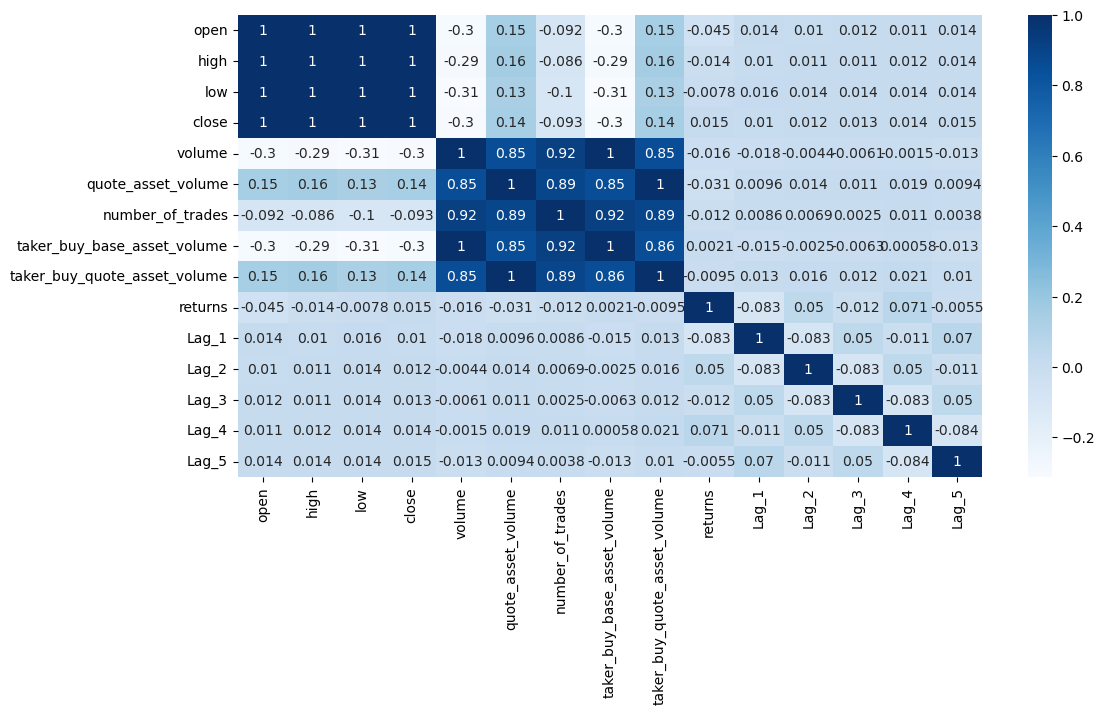

In [135]:
plt.figure(figsize=(12,6))

sns.heatmap(df.corr(), cmap='Blues', annot=True)
plt.show()

In [136]:
lr = LinearRegression()

In [137]:
X = df[lagnames]
y = df['returns']
lr.fit(X, y)

LinearRegression()

In [138]:
df['prediction_LR'] = lr.predict(df[lagnames])
df['direction_LR'] = [1 if i>0 else -1 for i in df.prediction_LR]
df['strat_LR'] = df['direction_LR'] * df['returns']

np.exp(df[['returns', 'strat_LR']].sum())

returns      7.505090
strat_LR    32.739152
dtype: float64

<Axes: xlabel='timestamp'>

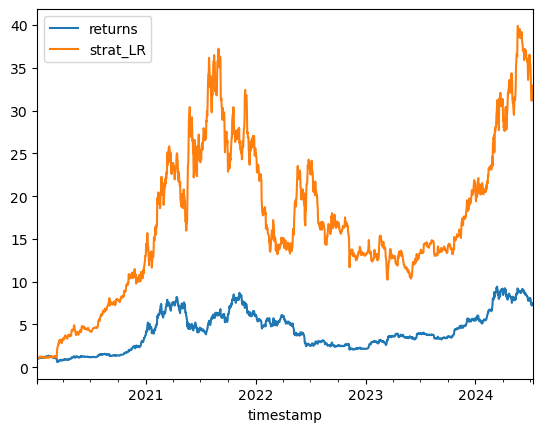

In [139]:
np.exp(df[['returns', 'strat_LR']].cumsum()).plot()

Part 2 - Xtrain, Xtest, ytrain, ytest

In [140]:
#Train test split
train, test = train_test_split(df, test_size=0.2, random_state=42, shuffle=False)

In [141]:
train = train.copy()
test = test.copy()

In [142]:
lr = LinearRegression()

In [143]:
lr.fit(train[lagnames], train['returns'])

LinearRegression()

In [144]:
test['predictions_LR'] = lr.predict(test[lagnames]) #Make predictions using model on lags
test['direction_LR'] = [1 if i>0 else -1 for i in test.prediction_LR] #1 or -1 based on sign of predictions
test['strat_LR'] = test['direction_LR'] * test['returns'] #Return for given prediction

np.exp(test[['returns', 'strat_LR']].sum())

returns     2.186966
strat_LR    2.449831
dtype: float64

<Axes: xlabel='timestamp'>

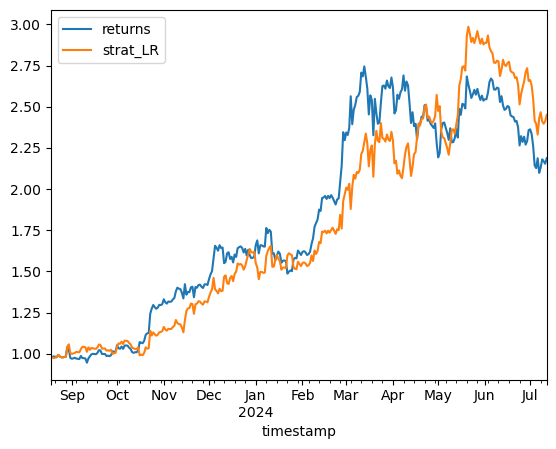

In [145]:
np.exp(test[['returns', 'strat_LR']].cumsum()).plot()

In [146]:
def get_next_date(df):
    last_date = df.index[-1]
    return last_date + timedelta(days=1)

def create_tomorrow_row(df, lagnames):
    tomorrow = get_next_date(df)
    new_row = pd.DataFrame(index = [tomorrow])

    for i, lag in enumerate(lagnames, 1):
        new_row[lag] = df['returns'].iloc[-1]
    return new_row

In [147]:
tomorrow_row = create_tomorrow_row(df, lagnames)
df.tail()

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,returns,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,prediction_LR,direction_LR,strat_LR
timestamp,,,,,,,,,,,,,,,,,,
2024-07-08,55857.81,58236.73,54260.16,56714.62,48090.20490,2.699943e+09,2554389.0,23963.90684,1.346498e+09,0.015223,-0.041594,0.027885,-0.007411,-0.053887,-0.031502,0.001692,1,0.015223
2024-07-09,56714.61,58296.00,56289.45,58050.00,27732.20788,1.592351e+09,1757693.0,14143.25001,8.122493e+08,0.023273,0.015223,-0.041594,0.027885,-0.007411,-0.053887,-0.002523,-1,-0.023273
2024-07-10,58050.00,59470.00,57157.79,57725.85,24951.73799,1.452293e+09,1766696.0,12423.53162,7.232096e+08,-0.005600,0.023273,0.015223,-0.041594,0.027885,-0.007411,0.001773,1,-0.005600
2024-07-11,57725.85,59650.00,57050.00,57339.89,29761.05735,1.728930e+09,2157661.0,15019.30135,8.729867e+08,-0.006709,-0.005600,0.023273,0.015223,-0.041594,0.027885,-0.000122,-1,0.006709
2024-07-12,57339.89,58278.00,56542.47,58224.49,17305.47559,9.926931e+08,1221262.0,8437.31250,4.842768e+08,0.015310,-0.006709,-0.005600,0.023273,0.015223,-0.041594,0.002289,1,0.015310


In [148]:
columns_to_keep = lagnames + ['returns', 'close']
df2 = df[columns_to_keep].copy()

df2.tail()

,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,returns,close
timestamp,,,,,,,
2024-07-08,-0.041594,0.027885,-0.007411,-0.053887,-0.031502,0.015223,56714.62
2024-07-09,0.015223,-0.041594,0.027885,-0.007411,-0.053887,0.023273,58050.00
2024-07-10,0.023273,0.015223,-0.041594,0.027885,-0.007411,-0.005600,57725.85
2024-07-11,-0.005600,0.023273,0.015223,-0.041594,0.027885,-0.006709,57339.89
2024-07-12,-0.006709,-0.005600,0.023273,0.015223,-0.041594,0.015310,58224.49


In [149]:
next_date = df2.index[-1] + timedelta(days=1)
new_row = pd.DataFrame(index=[next_date], columns=df2.columns)

new_row['Lag_1'] = df2['returns'].iloc[-1]
new_row['Lag_2'] = df2['Lag_1'].iloc[-1]
new_row['Lag_3'] = df2['Lag_2'].iloc[-1]
new_row['Lag_4'] = df2['Lag_3'].iloc[-1]
new_row['Lag_5'] = df2['Lag_4'].iloc[-1]

new_row['returns'] = np.nan

df2 = pd.concat([df2, new_row])

df2.tail()

/var/folders/v1/kyy1qs715rbg2rqbmr3z3rb40000gn/T/ipykernel_19326/1907290806.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df2 = pd.concat([df2, new_row])


,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,returns,close
2024-07-09,0.015223,-0.041594,0.027885,-0.007411,-0.053887,0.023273,58050.00
2024-07-10,0.023273,0.015223,-0.041594,0.027885,-0.007411,-0.005600,57725.85
2024-07-11,-0.005600,0.023273,0.015223,-0.041594,0.027885,-0.006709,57339.89
2024-07-12,-0.006709,-0.005600,0.023273,0.015223,-0.041594,0.015310,58224.49
2024-07-13,0.015310,-0.006709,-0.005600,0.023273,0.015223,NaN,NaN


Part 3 - Figuring out tomorrow returns

In [150]:
df.tail()

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,returns,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,prediction_LR,direction_LR,strat_LR
timestamp,,,,,,,,,,,,,,,,,,
2024-07-08,55857.81,58236.73,54260.16,56714.62,48090.20490,2.699943e+09,2554389.0,23963.90684,1.346498e+09,0.015223,-0.041594,0.027885,-0.007411,-0.053887,-0.031502,0.001692,1,0.015223
2024-07-09,56714.61,58296.00,56289.45,58050.00,27732.20788,1.592351e+09,1757693.0,14143.25001,8.122493e+08,0.023273,0.015223,-0.041594,0.027885,-0.007411,-0.053887,-0.002523,-1,-0.023273
2024-07-10,58050.00,59470.00,57157.79,57725.85,24951.73799,1.452293e+09,1766696.0,12423.53162,7.232096e+08,-0.005600,0.023273,0.015223,-0.041594,0.027885,-0.007411,0.001773,1,-0.005600
2024-07-11,57725.85,59650.00,57050.00,57339.89,29761.05735,1.728930e+09,2157661.0,15019.30135,8.729867e+08,-0.006709,-0.005600,0.023273,0.015223,-0.041594,0.027885,-0.000122,-1,0.006709
2024-07-12,57339.89,58278.00,56542.47,58224.49,17305.47559,9.926931e+08,1221262.0,8437.31250,4.842768e+08,0.015310,-0.006709,-0.005600,0.023273,0.015223,-0.041594,0.002289,1,0.015310


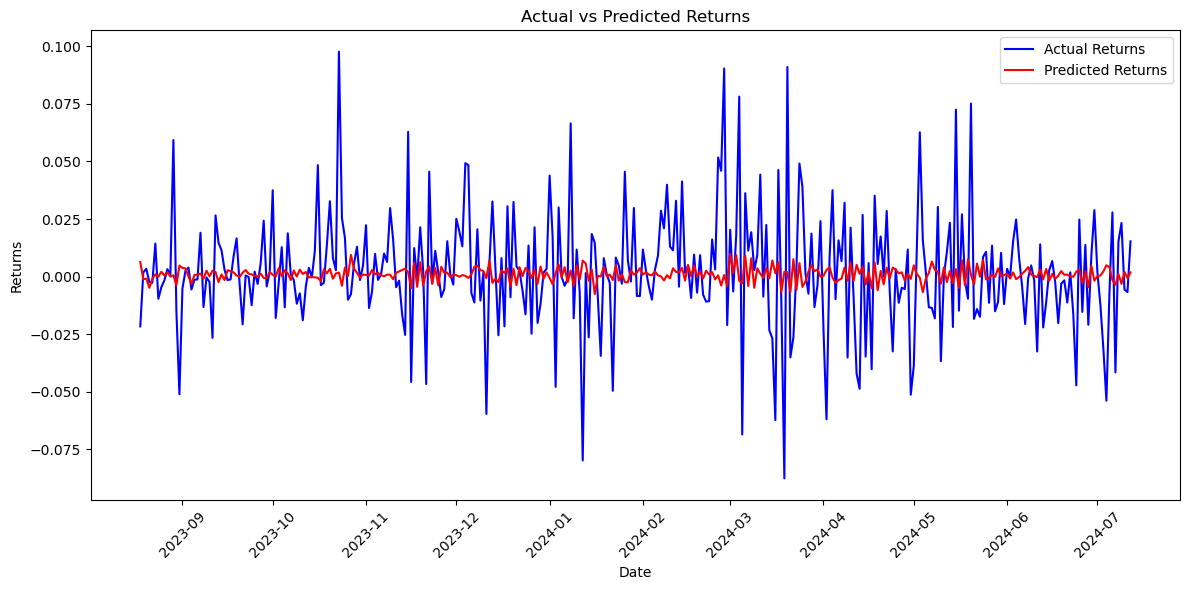

In [151]:
X = df[lagnames]
y = df['returns']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

lr = LinearRegression()

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test[lagnames])

plt.figure(figsize=(12, 6))
plt.plot(X_test.index, y_test, label='Actual Returns', color='blue')
plt.plot(X_test.index, y_pred, label='Predicted Returns', color='red')
plt.title('Actual vs Predicted Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [152]:
# Calculate metrics
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = metrics.mean_absolute_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.6f}")
print(f"Root Mean Squared Error: {rmse:.6f}")
print(f"Mean Absolute Error: {mae:.6f}")
print(f"R-squared Score: {r2:.6f}")

Mean Squared Error: 0.000646
Root Mean Squared Error: 0.025422
Mean Absolute Error: 0.017809
R-squared Score: 0.002595


In [153]:
correlation = np.corrcoef(y_test, y_pred)[0, 1]
print(f"Correlation between actual and predicted returns: {correlation:.6f}")

Correlation between actual and predicted returns: 0.082767


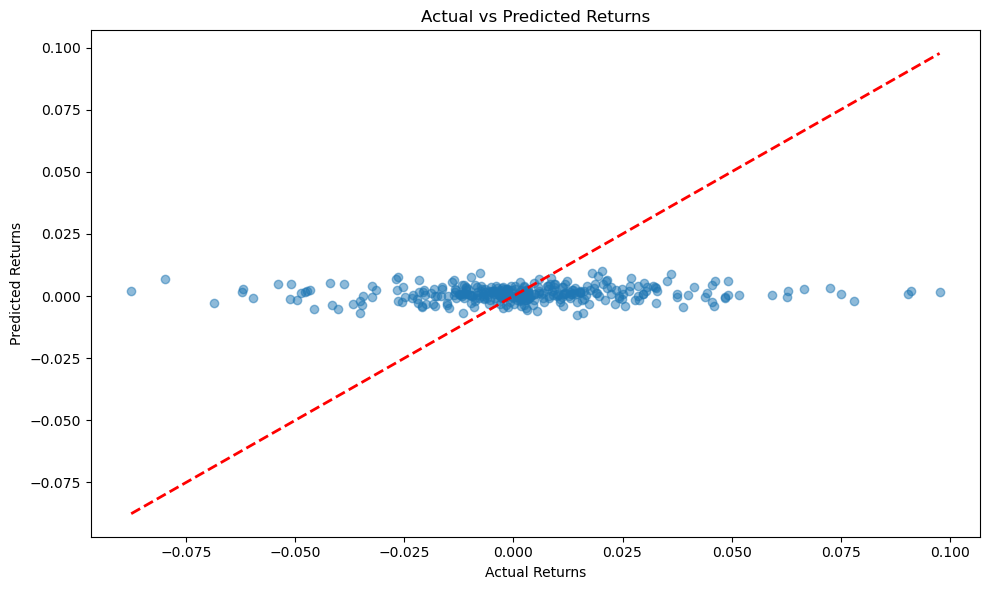

In [154]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Returns')
plt.ylabel('Predicted Returns')
plt.title('Actual vs Predicted Returns')
plt.tight_layout()
plt.show()

In [155]:
#Coefficients of model
for name, coef in zip(lagnames, lr.coef_):
    print(f"{name}: {coef:.6f}")
print(f"Intercept: {lr.intercept_:.6f}")

Lag_1: -0.076153
Lag_2: 0.042951
Lag_3: -0.007123
Lag_4: 0.073549
Lag_5: 0.006918
Intercept: 0.000889


In [156]:
directional_accuracy = np.mean((y_test > 0) == (y_pred > 0))
print(f"Directional Accuracy: {directional_accuracy:.6f}")

Directional Accuracy: 0.530303


In [157]:
test = pd.concat([X_test, y_test], axis = 1)

test.head()

,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,returns
timestamp,,,,,,
2023-08-18,-0.076169,-0.016209,-0.007877,0.004328,-0.004302,-0.021620
2023-08-19,-0.021620,-0.076169,-0.016209,-0.007877,0.004328,0.001764
2023-08-20,0.001764,-0.021620,-0.076169,-0.016209,-0.007877,0.003442
2023-08-21,0.003442,0.001764,-0.021620,-0.076169,-0.016209,-0.002411
2023-08-22,-0.002411,0.003442,0.001764,-0.021620,-0.076169,-0.002718


In [158]:
test = pd.concat([X_test, y_test], axis = 1)

test['predictions_LR'] = lr.predict(test[lagnames]) #Make predictions using model on lags
test['direction_LR'] = [1 if i>0 else -1 for i in test.predictions_LR] #1 or -1 based on sign of predictions
test['strat_LR'] = test['direction_LR'] * test['returns'] #Return for given prediction

np.exp(test[['returns', 'strat_LR']].sum())

returns     2.186966
strat_LR    2.648680
dtype: float64

<Axes: xlabel='timestamp'>

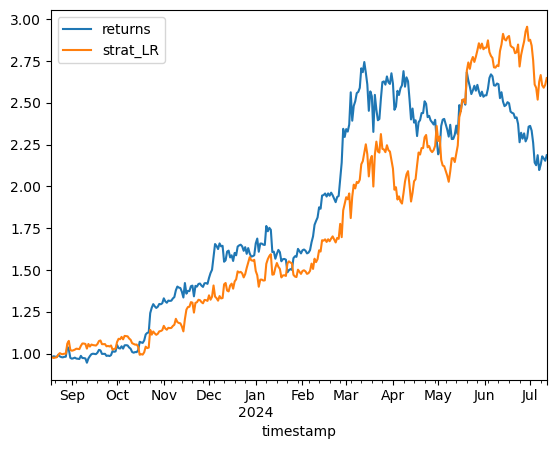

In [159]:
np.exp(test[['returns', 'strat_LR']].cumsum()).plot()

In [160]:
test.tail()

,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,returns,predictions_LR,direction_LR,strat_LR
timestamp,,,,,,,,,
2024-07-08,-0.041594,0.027885,-0.007411,-0.053887,-0.031502,0.015223,0.001125,1,0.015223
2024-07-09,0.015223,-0.041594,0.027885,-0.007411,-0.053887,0.023273,-0.003174,-1,-0.023273
2024-07-10,0.023273,0.015223,-0.041594,0.027885,-0.007411,-0.005600,0.002066,1,-0.005600
2024-07-11,-0.005600,0.023273,0.015223,-0.041594,0.027885,-0.006709,-0.000660,-1,0.006709
2024-07-12,-0.006709,-0.005600,0.023273,0.015223,-0.041594,0.015310,0.001825,1,0.015310


In [165]:
#Predict tomorrow using model built on train set
#Set up row for tomorrow with appropriate lags

new_row = pd.DataFrame(index = [datetime(2024,7,13)], columns=test.columns)

new_row['Lag_1'] = df.loc['2024-07-12', 'returns']
new_row['Lag_2'] = df.loc['2024-07-12', 'Lag_1']
new_row['Lag_3'] = df.loc['2024-07-12', 'Lag_2']
new_row['Lag_4'] = df.loc['2024-07-12', 'Lag_3']
new_row['Lag_5'] = df.loc['2024-07-12', 'Lag_4']

X_tomorrow = new_row[['Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5']].values.reshape(1, -1)

tomorrow_prediction = lr.predict(X_tomorrow)[0]

new_row['predictions_LR'] = tomorrow_prediction
new_row['direction_LR'] = 1 if tomorrow_prediction > 0 else -1

test2 = pd.concat([test, new_row])

test2.tail()

/Users/brandonamarasingam/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/var/folders/v1/kyy1qs715rbg2rqbmr3z3rb40000gn/T/ipykernel_19326/1271189724.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test2 = pd.concat([test, new_row])


,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,returns,predictions_LR,direction_LR,strat_LR
2024-07-09,0.015223,-0.041594,0.027885,-0.007411,-0.053887,0.023273,-0.003174,-1,-0.023273
2024-07-10,0.023273,0.015223,-0.041594,0.027885,-0.007411,-0.005600,0.002066,1,-0.005600
2024-07-11,-0.005600,0.023273,0.015223,-0.041594,0.027885,-0.006709,-0.000660,-1,0.006709
2024-07-12,-0.006709,-0.005600,0.023273,0.015223,-0.041594,0.015310,0.001825,1,0.015310
2024-07-13,0.015310,-0.006709,-0.005600,0.023273,0.015223,NaN,0.001291,1,NaN
